# CLASSIFICATION WITH EXTREME GRADIENT BOOSTING

by ChunkDevs (Group 1)

XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework.

We decided to use this model becouse the author of the dataset have reached their best scores using this algorithm (94% accuracy, removing the not cyberbullying label)

We trained an `XGBoost classifier` on our tweet data transformed by Count Vectorizer (BOW), while exploring different combinations of hyperparameters through grid search to find the optimal configuration for the best classification results.

After the gridsearch we show our result in the notebook

In [1]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from _chunkdevs.models import ChunkDevs_GridTrainer, ModelHandler
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif

c:\Users\ASUS\anaconda3\envs\HLT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DATA LOADING

In [3]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

In [4]:
RANDOM_STATE = 42

k_fold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

path_models = os.path.join(root_path, 'outputs', 'models')

In [5]:
X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

# BINARY CLASSIFICATION TASK

We trained an `XGBoost classifier` on our tweet data transformed by Count Vectorizer (BOW), while exploring different combinations of hyperparameters through grid search to find the optimal configuration for the best classification results.

The hyperparameters chosen are the following:
1.  `n_estimators`: determines the number of boosting rounds or trees to build;
2.  `max_depth`: controls the maximum depth of each tree in the ensemble;
3.  `learning_rate`: controls the shrinkage applied to each tree's prediction during training;
4.  `min_child_weight`: defines the minimum sum of instance weight needed in child;
5.  `gamma`: controls the minimum loss reduction required to make a further partition on a leaf node.





In [6]:
vectorizer = CountVectorizer()
model_bin = xgb.XGBClassifier(random_state=RANDOM_STATE, colsample_bytree=.6, subsample=.7)

X_dev_bin = vectorizer.fit_transform(X_dev_bin)
X_test_bin = vectorizer.transform(X_test_bin)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05, 0.25] ,
    'min_child_weight': [1, 2],
    'gamma': [0.0, 0.1, 0.5]
}

## MODEL SELECTION

In [7]:
# binary classification with F1-score as evaluation metric

'''

trainer = ChunkDevs_GridTrainer(model=model_bin, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)
best_model_bin = trainer.train(X_train_bin, y_dev_bin)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

'''

'\n\ntrainer = ChunkDevs_GridTrainer(model=model_bin, param_grid=param_grid, scoring="f1_weighted", cv=k_fold, n_jobs=-1)\nbest_model_bin = trainer.train(X_train_bin, y_dev_bin)\nbest_params = trainer.get_best_params()\nprint(f"Best Parameters: {best_params} \n")\n\n'

## MODEL LOADING (for **not repeating the gridsearch**)

Since the greadsearch can take a long time (almost 2 hours and a half), we leave our model to be loaded, with best parameters:

- `n_estimators` = 500,
- `max_depth` = 30,
- `learning_rate`= 0.05,
- `min_child_weight` = 1,
- `gamma` = 0.0


In [8]:
#Handler = ModelHandler(path_models)
#best_model_bin = Handler.load_model("xgboost_binary")
#best_model_bin

## TESTING PHASE

Testing of the assessed model to the test-set and showing our results

In [9]:
best_model_bin = xgb.XGBClassifier(random_state=RANDOM_STATE, colsample_bytree=.6, subsample=.7,
                                    n_estimators = 500,
                                    max_depth = 30,
                                    learning_rate= 0.05,
                                    min_child_weight = 1,
                                    gamma = 0.0
)

best_model_bin.fit(X_dev_bin, y_dev_bin)
y_pred_bin = best_model_bin.predict(X_test_bin)
report = classification_report(y_true=  y_test_bin, y_pred = y_pred_bin)
print(report) 

              precision    recall  f1-score   support

           0       0.65      0.48      0.55       487
           1       0.90      0.95      0.92      2435

    accuracy                           0.87      2922
   macro avg       0.77      0.71      0.74      2922
weighted avg       0.86      0.87      0.86      2922



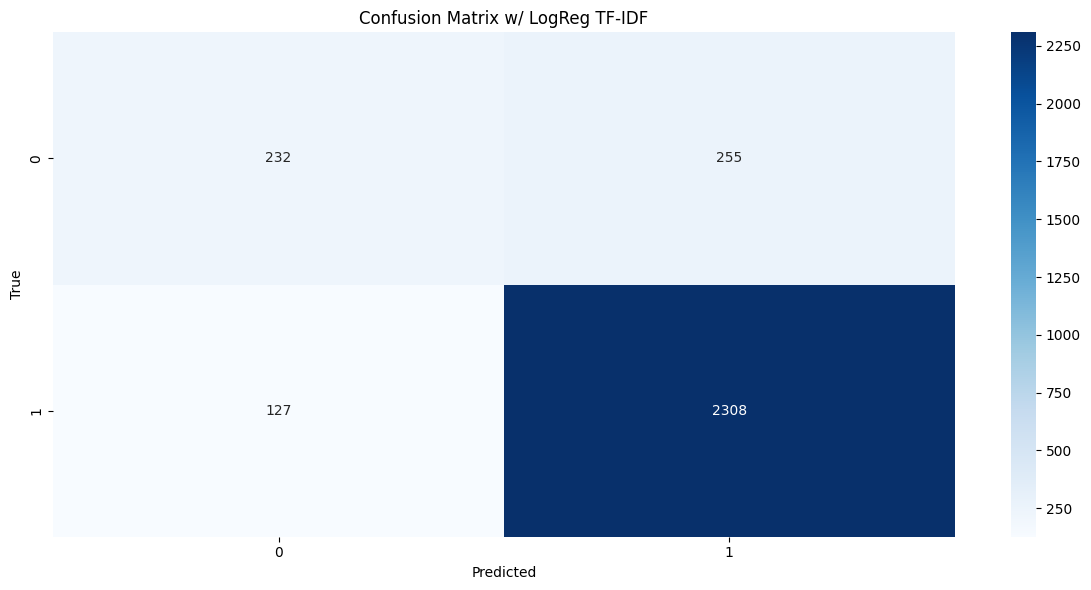

In [10]:
matrix = confusion_matrix(y_test_bin, y_pred_bin)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix XGboost Binary')
plt.tight_layout()
# plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '7_XGB_binary.png'))
plt.show()

### RESULTS SAVING

Saving the results to the appripriate 

In [11]:
save_path = os.path.join(root_path, 'outputs', 'reports', '4_svc_countvect.txt')

if type(best_model_bin) == ChunkDevs_GridTrainer:
   
    best_model_bin.save_results(X_test_bin, y_test_bin, save_path)

else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Write the report contents to a file
        with open(save_path, 'a') as file:
            file.write(f"Model: 4_svc_countvect\n")
            file.write(f"Best Parameters: {best_model_bin.get_params()}\n")
            file.write(f"Classification Report:\n{report}\n")

        # Print a confirmation message.
        print(f"Report saved to {save_path}") 

Report saved to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\reports\4_svc_countvect.txt


# MULTICLASSIFICATION TASK  

We repeat the same procedure as before, ando look for the model with the best accuracy

In [12]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

## MODEL SELECTION

In [13]:
vectorizer = CountVectorizer()
model_multi = xgb.XGBClassifier(random_state=RANDOM_STATE, colsample_bytree=.6, subsample=.7)

X_dev_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05, 0.25] ,
    'min_child_weight': [1, 2],
    'gamma': [0.0, 0.1, 0.5]
}

In [14]:
# multiclass classification with accuracy as evaluation metric
'''

trainer = ChunkDevs_GridTrainer(model=model_multi, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_multi = trainer.train(X_train_multi, y_dev_multi)
best_params = trainer.get_best_params()
print(f"Best Parameters: {best_params} \n")

'''

'\n\ntrainer = ChunkDevs_GridTrainer(model=model_multi, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)\nbest_model_multi = trainer.train(X_train_multi, y_dev_multi)\nbest_params = trainer.get_best_params()\nprint(f"Best Parameters: {best_params} \n")\n\n'

## MODEL LOADING (for **not repeating the gridsearch**)


Since the greadsearch can take a long time, we leave our model to be loaded, with best parameters:

- `n_estimators` = 500,
- -`max_depth` = 30,
- `learning_rate`= 0.05,
- `min_child_weight` = 1,
- `gamma` = 0.1



In [15]:
"""
model_path = os.path.join(root_path, 'outputs', 'models')
Handler = ModelHandler(model_path)
best_model_multi = Handler.load_model("xgboost_multi")
best_model_multi
"""




'\nmodel_path = os.path.join(root_path, \'outputs\', \'models\')\nHandler = ModelHandler(model_path)\nbest_model_multi = Handler.load_model("xgboost_multi")\nbest_model_multi\n'

## TESTING PHASE

In [16]:
best_model_multi = xgb.XGBClassifier(random_state=RANDOM_STATE, colsample_bytree=.6, subsample=.7,
                                    n_estimators = 500,
                                    max_depth = 30,
                                    learning_rate= 0.05,
                                    min_child_weight = 1,
                                    gamma = 0.1
)

best_model_multi.fit(X_dev_multi, y_dev_multi)

y_pred_multi = best_model_multi.predict(X_test_multi)
report = classification_report(y_true=  y_test_multi, y_pred = y_pred_multi)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       487
           1       0.99      0.99      0.99       487
           2       0.93      0.85      0.89       487
           3       0.60      0.62      0.61       487
           4       0.65      0.72      0.68       487
           5       0.97      0.94      0.96       487

    accuracy                           0.85      2922
   macro avg       0.85      0.85      0.85      2922
weighted avg       0.85      0.85      0.85      2922



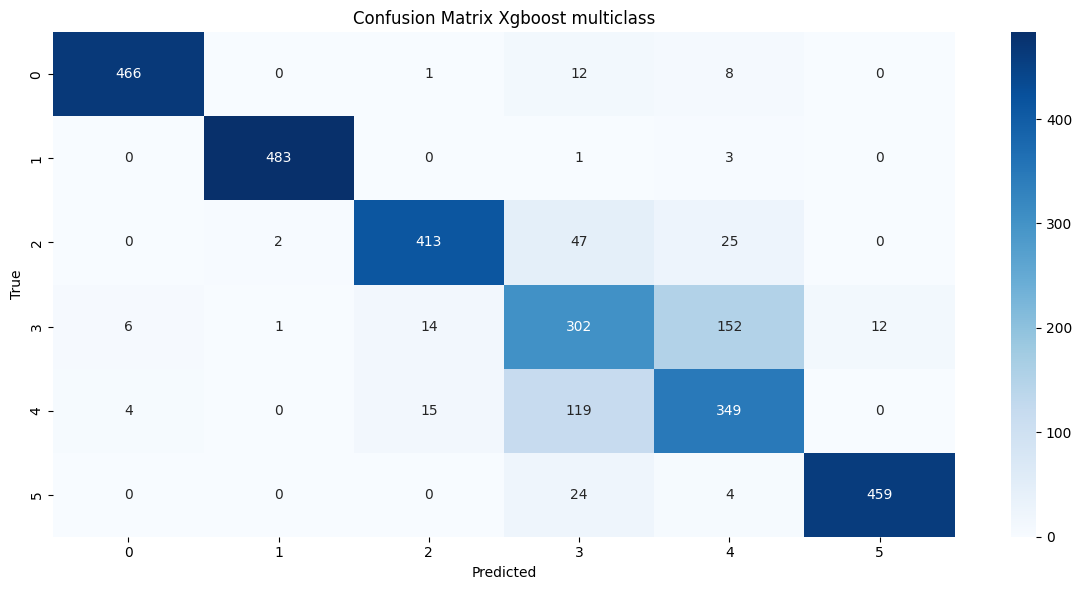

In [17]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Xgboost multiclass')
plt.tight_layout()
# plt.savefig(os.path.join(root_path, 'outputs', 'img', 'baseline', '7_cm_logreg_tfidf_multi.png'))
plt.show()

### RESULTS SAVING

Saving the results to the appripriate 

In [18]:
save_path = os.path.join(root_path, 'outputs', 'reports', '4_svc_countvect.txt')

if type(best_model_multi) == ChunkDevs_GridTrainer:
   
    best_model_multi.save_results(X_test_bin, y_test_bin, save_path)

else:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Write the report contents to a file
        with open(save_path, 'a') as file:
            file.write(f"Model: 4_svc_countvect\n")
            file.write(f"Best Parameters: {best_model_multi.get_params()}\n")
            file.write(f"Classification Report:\n{report}\n")

        # Print a confirmation message.
        print(f"Report saved to {save_path}")

Report saved to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\reports\4_svc_countvect.txt


# MODEL SAVING

Saving the models to the appropriate folder

In [19]:
# saving of the best models after grid search
handler = ModelHandler(path_models)


models = {
    "xgboost_binary" : best_model_bin,
    "xgboost_multi" : best_model_multi
}

handler.save_models(models)

--------------------------------------------------------------------------------------------------------------------------------------------------
| Save model 'xgboost_binary' to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\models\xgboost_binary.pkl |
--------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------
| Save model 'xgboost_multi' to c:\Users\ASUS\OneDrive - University of Pisa\Human language technologies\V_HLT\outputs\models\xgboost_multi.pkl |
------------------------------------------------------------------------------------------------------------------------------------------------


<div style="font-size: 22px;">    

Turning to the results for advanced models in the binary task, we observe notable improvements in the metrics.

The XGBoost model demonstrates a **significant strength** with a precision of 65% for non-cyberbullying (0) and 90% for cyberbullying (1), along with a recall of 48% for non-cyberbullying and an impressive 95% for cyberbullying. The resulting F1-scores are 55% and 92% for non-cyberbullying and cyberbullying, respectively.

In the multiclass task, the advanced models also exhibit strong performance. The XGBoost model achieves the highest accuracy at 85%, indicating its effectiveness in handling the complexity of multiclass classification. 

However, besides the pros, this model has very important cons, like its low recall recall value for the class 0 for binary classification, the long time for the grid search and the fact that, commonly with the other models, XGB confuses the not cyberbullying class with the not cyberbullying class

<br></div>

# COMPARING XGBOOSTING TO THE STATE OF THE ART MODEL

In this phase, we tried to compare the preformances of our model with the one used from the authors of the dataset 

In [ ]:
dev = dev.loc[dev['cyberbullying_type_multi'] != 3, :]

dev.loc[dev['cyberbullying_type_multi'] == 5, 'cyberbullying_type_multi'] = 3

y_dev_multi = dev['cyberbullying_type_multi'].values

test = test.loc[test['cyberbullying_type_multi'] != 3, :]

test.loc[test['cyberbullying_type_multi'] == 5, 'cyberbullying_type_multi'] = 3

y_test_multi = test['cyberbullying_type_multi'].values


X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

After adapting the train and test labels, we proceed with the taining and testing of the model

In [ ]:
vectorizer = CountVectorizer()
model_multi = xgb.XGBClassifier(random_state=RANDOM_STATE, colsample_bytree=.6, subsample=.7)

X_train_multi = vectorizer.fit_transform(X_dev_multi)
X_test_multi = vectorizer.transform(X_test_multi)

"""param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05, 0.25] ,
    'min_child_weight': [1, 2],
    'gamma': [0.0, 0.1, 0.5]
}"""

param_grid = {
    'n_estimators': [300],
    'max_depth': [30],
    'learning_rate': [0.05],
    'min_child_weight': [1],
    'gamma': [0.1]
}

# multiclass classification with accuracy as evaluation metric
trainer = ChunkDevs_GridTrainer(model=model_multi, param_grid=param_grid, scoring="accuracy", cv=k_fold, n_jobs=-1)
best_model_multi = trainer.train(X_train_multi, y_dev_multi)
y_pred_multi = trainer.predict(X_test_multi)
best_params = trainer.get_best_params()
best_score = trainer.get_best_score()
report = trainer.get_classification_report(X_test_multi, y_test_multi)
print(f"Best Parameters: {best_params} \n")
print(f"Best Score: {best_score} \n")
print(report)

In [ ]:
matrix = confusion_matrix(y_test_multi, y_pred_multi)

plt.figure(figsize=(12, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix w/ LogReg TF-IDF')
plt.tight_layout()
# plt.savefig(os.path.join(root_path, 'outputs', 'img', '2_advanced_models', 'XGB_VS_SOA.png'))
plt.show()

<div style="font-size: 18px;">   

As we can notice from the results, it seems that our model has an **higher accuracy** than the authors models. It is necessary to consider that the dimension of the train and test data are different, since we tested our model using more training data. Moreover, our better performances might be due to the language filtering and the text cleaning that we have done in the preprocessing step.

<br></div>